# ¿Se puede medir el bienestar de un país en función de las emociones encontradas en las canciones más escuchadas? (Análisis Descriptivo Básico)
* Actividad 2 Grupal del CUA de Data Analyst, Análisis e Interpretación de Datos, UNIR 2023
    * Realizado por:
            * David Toscano Recalde
            * Nicolás Felipe Trujillo Montero
            * Iris Aguado Fernández

## Descripción
Nuestro objetivo es realizar un análisis tomando de muestra aleatoria de personas de EEUU para observar si existe una relación entre la canción más escuchada en un país y la situación económica del país. Para ello, partiremos de una serie de datos y realizaremos un par de análisis descriptivos, uno general y uno robusto para llegar a una conclusión. 

Los datos son los siguientes:
* Top 1 de Spotify (charts.csv): Se trata de un dataframe completo de todas las canciones top 200 y virales 50 gráficos publicados globalmente por Spotify. (Fuente: https://www.kaggle.com/datasets/dhruvildave/spotify-charts?resource=download)
* Lista de Canciones junto con Emocion asociadas (muse_v3.csv): Se trata de un dataframe que asocia 90.000 canciones con una emoción asociada a la canción en función de la letra de la canción. (Fuente: https://www.kaggle.com/code/cakiki/muse-dataset-getting-started/data)
* Datos Macroeconómicos a nivel global (US_SECONOMICS_2.csv): Se trata de un dataframe que por cada país y año nos indica los indicadores del país. (Fuente: https://data.worldbank.org/indicator/SL.UEM.TOTL.ZS)



## Importamos librerías y Datos

In [1]:
######################################################
# Tratamiento de Datos
######################################################
import pandas as pd
import numpy as np
from datetime import datetime
import re

######################################################
# Gráficos
######################################################
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# DF Top Spotify
df_top_original = pd.read_csv("charts.csv")  

# DF Etiquetas X Cancion
df_labels_original = pd.read_csv("muse_v3.csv")

# DF Variables Macroec
socioeco_original = pd.read_csv("US_SECONOMICS_2.csv")

## Depuración y Filtración para hacer el análisis

1.- Nos quedamos con el top 1 de solo nuestro tamaño de la muestra, es decir, Estados Unidos

NOTA: El valor de streams es NaN cuando la columna chart es "viral50".

In [3]:
df_top = df_top_original.copy()
_eeuuFilter=df_top_original["region"]=="United States"
df_top = df_top_original[_eeuuFilter].reset_index().drop(columns=['index'], axis=1)
df_top["streams"] = df_top["streams"].fillna("NO")
display(df_top.head(5))

,title,rank,date,artist,url,region,chart,trend,streams
0,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.0
1,Fake Love,2,2017-01-01,Drake,https://open.spotify.com/track/343YBumqHu19cGo...,United States,top200,SAME_POSITION,1180074.0
2,Starboy,3,2017-01-01,"The Weeknd, Daft Punk",https://open.spotify.com/track/5aAx2yezTd8zXrk...,United States,top200,SAME_POSITION,1064351.0
3,Closer,4,2017-01-01,"The Chainsmokers, Halsey",https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,United States,top200,SAME_POSITION,1010492.0
4,Black Beatles,5,2017-01-01,"Rae Sremmurd, Gucci Mane",https://open.spotify.com/track/6fujklziTHa8uoM...,United States,top200,SAME_POSITION,874289.0


2.- Realizamos un filtrado para poder juntar df_top con df_labels.

In [4]:
df_labels = df_labels_original.copy()


# Cambiamos la columna track por title para poder juntarlo con df_top
df_labels.rename(columns = {'track':'title'}, inplace = True)

# Tenemos que ver si hay valores NA, y si los hay ver si nos merece la pena eliminarlos.
print(df_labels.count())
display(df_labels["genre"])

lastfm_url                90001
title                     90001
artist                    90001
seeds                     90001
number_of_emotion_tags    90001
valence_tags              90001
arousal_tags              90001
dominance_tags            90001
mbid                      61217
spotify_id                61630
genre                     83362
dtype: int64


0                     rap
1                   metal
2                     rap
3                 hip-hop
4                   metal
               ...       
89996                 NaN
89997    progressive rock
89998                 NaN
89999                 NaN
90000             ambient
Name: genre, Length: 90001, dtype: object

In [5]:
df_labels.drop(df_labels[df_labels['genre'].isna()].index, inplace = True)
display(df_labels.count())

lastfm_url                83362
title                     83362
artist                    83362
seeds                     83362
number_of_emotion_tags    83362
valence_tags              83362
arousal_tags              83362
dominance_tags            83362
mbid                      58559
spotify_id                58687
genre                     83362
dtype: int64

In [6]:
df_merged = pd.merge(df_labels,df_top,how="inner", on = "title")
df_merged.drop(['mbid','spotify_id'], axis=1)
df_merged['date'] = pd.to_datetime(df_merged['date'],format="%Y-%m-%d")
df_merged["year"]=df_merged["date"].dt.year
df_merged["month"]=df_merged["date"].dt.month
df_merged.rename(columns = {'region':'COUNTRY'}, inplace = True)
display(df_merged.count())

lastfm_url                284803
title                     284803
artist_x                  284803
seeds                     284803
number_of_emotion_tags    284803
valence_tags              284803
arousal_tags              284803
dominance_tags            284803
mbid                      210823
spotify_id                247773
genre                     284803
rank                      284803
date                      284803
artist_y                  284803
url                       284803
COUNTRY                   284803
chart                     284803
trend                     284803
streams                   284803
year                      284803
month                     284803
dtype: int64

3.- Realizamos un filtrado de US_SECONOMICS 

In [7]:
socioeco = pd.read_csv("US_SECONOMICS_2.csv")
socioeco = socioeco.set_index('Indicator Name')
#socioeco.dropna(inplace=True)
socioeco.drop(columns=['Country Name', 'Country Code',"Indicator Code"],inplace=True)
socioeco=socioeco.reset_index()
socioeco.set_index('Indicator Name')
socioeco.rename(columns = {'Indicator Name':'year'}, inplace = True)
socioeco.head(2)
socioeco = socioeco.melt('year').pivot('variable', 'year', 'value').rename_axis(index='year', columns=None).reset_index()  
socioeco['year'] = socioeco['year'].astype("int64")
display(socioeco)

C:\Users\NicolasFTM\AppData\Local\Temp\ipykernel_1228\192668905.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  socioeco = socioeco.melt('year').pivot('variable', 'year', 'value').rename_axis(index='year', columns=None).reset_index()


,year,Consumer price index (2010 = 100),GNI per capita (constant LCU),"Inflation, GDP deflator (annual %)","Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth total (% of total labor force ages 15-24) (national estimate)"
0,2017,112.411557,59625.171237,1.899610,4.36,9.24
1,2018,115.157303,61024.329301,2.404059,3.90,8.61
2,2019,117.244195,62173.485113,1.793931,3.67,8.39
3,2020,118.690502,60010.506479,1.304912,8.05,14.92
4,2021,124.266414,63279.718625,4.492792,5.35,9.73


4.- Modificamos ambos dataframes para la union

In [8]:
df_merged.columns

Index(['lastfm_url', 'title', 'artist_x', 'seeds', 'number_of_emotion_tags',
       'valence_tags', 'arousal_tags', 'dominance_tags', 'mbid', 'spotify_id',
       'genre', 'rank', 'date', 'artist_y', 'url', 'COUNTRY', 'chart', 'trend',
       'streams', 'year', 'month'],
      dtype='object')

In [9]:
df_merged.drop(columns=["lastfm_url","url","chart","trend",
                        "mbid",
                        "spotify_id",	"genre",
                        "number_of_emotion_tags",	"valence_tags",	"arousal_tags",	"dominance_tags",
                        "artist_y"],inplace=True)

In [10]:
# df_top.dropna(inplace=True)
df_merged.count()

title       284803
artist_x    284803
seeds       284803
rank        284803
date        284803
COUNTRY     284803
streams     284803
year        284803
month       284803
dtype: int64

In [11]:
df_merged.sample(10)

,title,artist_x,seeds,rank,date,COUNTRY,streams,year,month
20697,Silence,Blindside,['calm'],188,2019-01-05,United States,201755.0,2019,1
249838,Promiscuous,Nelly Furtado,['sexy'],188,2020-11-15,United States,201640.0,2020,11
261357,In My Mind,SR-71,['nostalgic'],9,2018-07-21,United States,NO,2018,7
182162,GUMMO,6ix9ine,"['ethereal', 'sensual']",101,2018-02-16,United States,304537.0,2018,2
177275,Believer,American Authors,['fun'],161,2018-09-30,United States,217544.0,2018,9
250202,Redbone,Childish Gambino,['sexy'],69,2017-03-19,United States,371047.0,2017,3
70166,Closer,Flint Glass,"['apocalyptic', 'gloomy']",170,2018-06-28,United States,223163.0,2018,6
32293,Better,Plumb,['angry'],38,2019-03-10,United States,521393.0,2019,3
27364,Control,Control Alt Deus,['gritty'],144,2020-12-27,United States,233986.0,2020,12
145188,Heaven,Live,['sweet'],129,2018-07-17,United States,268810.0,2018,7


In [12]:
labels = ["angry", "aggressive",
            "romantic","optimistic","positive",
            "powerful",
            "light",
            "sad",
            "dramatic",
            "bitter",
            "smooth"]

def iscategory(x,y):
    return bool(re.search(x,y))

for word in labels:
    df_merged[word]=word
    df_merged[word] = df_merged.apply(lambda x1: iscategory(x1[word], x1['seeds']), axis=1)


In [13]:
df_merged.drop(df_merged[df_merged["streams"] == "NO"].index, inplace = True)

In [14]:
df_merged = df_merged.groupby(["year"]).agg(
    {
    "streams":"sum",
    "angry":'sum', 
    "aggressive":'sum',
    "romantic":'sum',
    "optimistic":'sum',
    "positive":'sum',
    "powerful":'sum',
    "light":'sum',
    "sad":'sum',
    "dramatic":'sum',
    "bitter":'sum',
    "smooth":'sum'
    })

In [15]:
display(df_merged.head(5))

,streams,angry,aggressive,romantic,optimistic,positive,powerful,light,sad,dramatic,bitter,smooth
year,,,,,,,,,,,,
2017,19613352139.0,714,1097,1659,412,369,959,1191,2237,1026,1522,1506
2018,21742534757.0,1283,952,2380,1375,347,2287,1306,3480,743,1294,1359
2019,17995873982.0,974,773,1171,355,214,1334,493,2751,432,730,1676
2020,13534490081.0,524,80,530,801,349,859,212,2707,131,508,449
2021,11252408261.0,283,208,936,436,202,852,246,1730,153,754,646


In [16]:
labels = ["angry", "aggressive",
            "romantic","optimistic","positive",
            "powerful",
            "light",
            "sad",
            "dramatic",
            "bitter",
            "smooth"]
for word in labels:
    df_merged[word]=df_merged[word].astype(np.float64)

## Se obtiene el df consolidado y depurado (df_master)

In [17]:
df_master = pd.merge(socioeco,df_merged,how="inner", on = ["year"])
df_master = df_master
df_master.head()

,year,Consumer price index (2010 = 100),GNI per capita (constant LCU),"Inflation, GDP deflator (annual %)","Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth total (% of total labor force ages 15-24) (national estimate)",streams,angry,aggressive,romantic,optimistic,positive,powerful,light,sad,dramatic,bitter,smooth
0,2017,112.411557,59625.171237,1.899610,4.36,9.24,19613352139.0,714.0,1097.0,1659.0,412.0,369.0,959.0,1191.0,2237.0,1026.0,1522.0,1506.0
1,2018,115.157303,61024.329301,2.404059,3.90,8.61,21742534757.0,1283.0,952.0,2380.0,1375.0,347.0,2287.0,1306.0,3480.0,743.0,1294.0,1359.0
2,2019,117.244195,62173.485113,1.793931,3.67,8.39,17995873982.0,974.0,773.0,1171.0,355.0,214.0,1334.0,493.0,2751.0,432.0,730.0,1676.0
3,2020,118.690502,60010.506479,1.304912,8.05,14.92,13534490081.0,524.0,80.0,530.0,801.0,349.0,859.0,212.0,2707.0,131.0,508.0,449.0
4,2021,124.266414,63279.718625,4.492792,5.35,9.73,11252408261.0,283.0,208.0,936.0,436.0,202.0,852.0,246.0,1730.0,153.0,754.0,646.0


# Apartir de aqui se debe iniciar el tratamiento 

C:\Users\NicolasFTM\AppData\Local\Temp\ipykernel_1228\2121862967.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_master.corr(method ='pearson') #por defecto Pearson ¿existe relación lineal entre variables?


[Text(0.5, 0, 'aggressive'),
 Text(1.5, 0, 'romantic'),
 Text(2.5, 0, 'optimistic'),
 Text(3.5, 0, 'positive'),
 Text(4.5, 0, 'powerful'),
 Text(5.5, 0, 'light'),
 Text(6.5, 0, 'sad'),
 Text(7.5, 0, 'dramatic'),
 Text(8.5, 0, 'bitter'),
 Text(9.5, 0, 'smooth')]

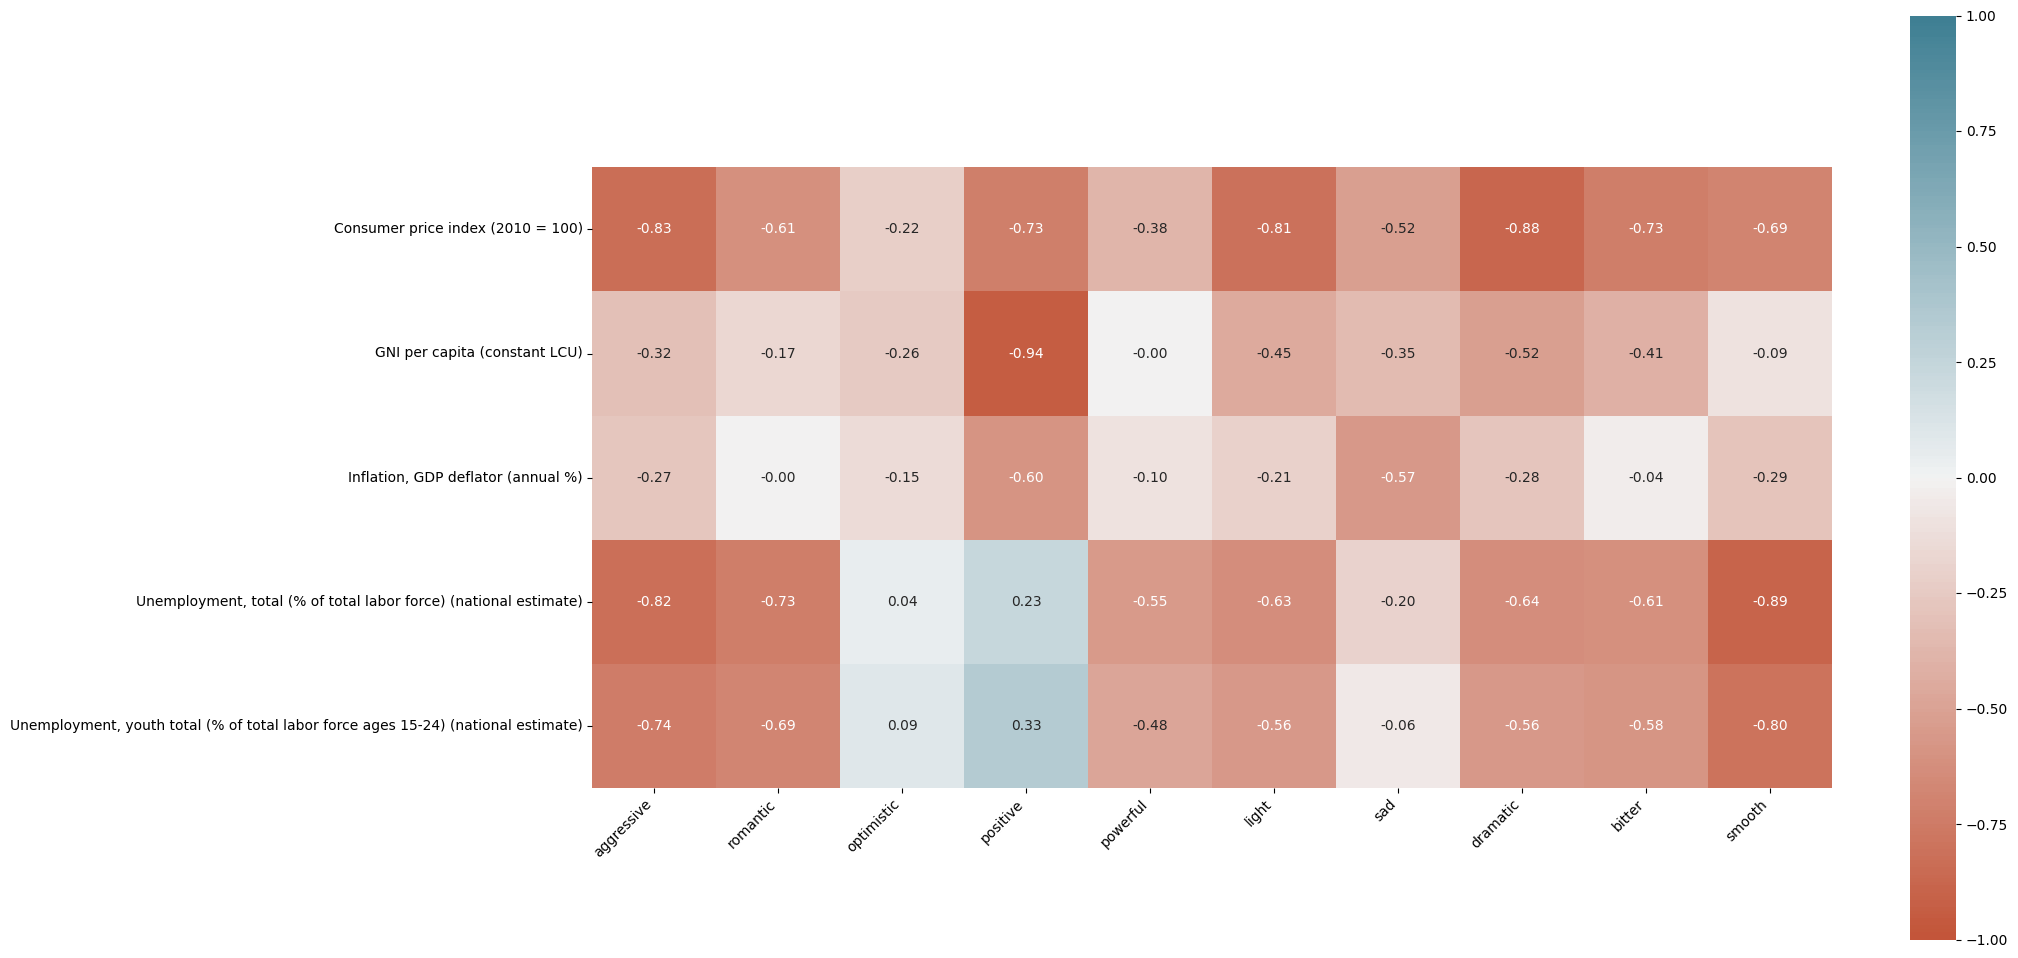

In [18]:
corr = df_master.corr(method ='pearson') #por defecto Pearson ¿existe relación lineal entre variables?
corr = corr.iloc[1:6,7:100]
# HeatMap con tamaño ampliado, cuadrado, divergencia con colores y con anotaciones de 2 decimales
plt.figure(figsize=(20,12))
ax = sns.heatmap(
 corr,
 vmin=-1, vmax=1, center=0,
 cmap=sns.diverging_palette(20, 220, n=200),
 square=True, annot=True, fmt=".2f"
)
# Rota las etiquetas del eje horizontal
ax.set_xticklabels(
 ax.get_xticklabels(),
 rotation=45,
 horizontalalignment='right'
)